In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import string
import nltk

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from sklearn.model_selection import train_test_split,StratifiedKFold, ParameterGrid

In [5]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score,f1_score

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from xgboost import XGBClassifier

In [8]:
from sklearn.svm import LinearSVC

In [9]:
from sklearn.naive_bayes import MultinomialNB

In [10]:
from lightgbm import LGBMClassifier

In [11]:
import psycopg2

In [12]:
from scipy.sparse import hstack,csr_matrix,issparse

In [13]:
from textblob import TextBlob
import textstat

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [18]:
load_dotenv()

True

In [19]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [20]:
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [21]:
engine = create_engine(DATABASE_URL)

In [22]:
train_df = pd.read_sql("SELECT * FROM train_data", engine)

In [23]:
def clean_texts(col): 
    col = col.lower() 
    col = re.sub(r"\d+", " num ", col)  
    col = re.sub(r"[^\w\s!?]", "", col)  
    col = " ".join([word for word in col.split() if word not in stopwords.words('english')])  
    return col

In [24]:
def convert_to_tfidf_vectorizer(df, text_col, max_features=5000, ngram_range=(1,2)):
    df = df.copy()
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df[text_col])
    
    return X_tfidf, vectorizer

In [25]:
def get_train_test(X, y, test_size=0.2, random_state=101):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y   
    )
    return X_train, X_test, y_train, y_test

In [26]:
def combine_features(X_tfidf, engineered_features):
    if not issparse(engineered_features):
        engineered_features = engineered_features.values
    
    return hstack([X_tfidf, engineered_features])

In [27]:
def get_all_feature_names(tfidf_vectorizer, engineered_features):
    tfidf_features = tfidf_vectorizer.get_feature_names_out()
    engineered_features_cols = engineered_features.columns
    return np.concatenate([tfidf_features, engineered_features_cols])

In [63]:
"""
def textblob_features(df,text_col):
    df = df.copy()
    blob = TextBlob(df['text_col'])
    return pd.Series([blob.sentiment.polarity,blob.sentiment.subjectivity])
    """

"\ndef textblob_features(df,text_col):\n    df = df.copy()\n    blob = TextBlob(df['text_col'])\n    return pd.Series([blob.sentiment.polarity,blob.sentiment.subjectivity])\n    "

In [73]:
def text_features(df, text_col):
    df = df.copy()
    
    # Readability features
    df['flesch'] = df[text_col].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    df['gunning_fog'] = df[text_col].apply(lambda x: textstat.gunning_fog(str(x)))
    
    # VADER features
    analyzer = SentimentIntensityAnalyzer()
    df['vader_neg'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['neg'])
    df['vader_neu'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['neu'])
    df['vader_pos'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['pos'])
    df['vader_compound'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    
    return df

In [42]:
def stratified_kfold_eval(X, y, model, n_splits=5):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies, f1_scores = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold =  X.tocsr()[train_idx], X.tocsr()[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        accuracies.append(accuracy_score(y_val_fold, y_pred))
        f1_scores.append(f1_score(y_val_fold, y_pred, average="macro"))

    results = {
        "mean_accuracy": np.mean(accuracies),
        "std_accuracy": np.std(accuracies),
        "mean_f1": np.mean(f1_scores),
        "std_f1": np.std(f1_scores)
    }

    return pd.DataFrame([results])


In [65]:
def evaluate_train_test(model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    
    # Print scores
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (macro): {f1:.4f}\n")
    
    # Classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.show()


In [66]:
df1 = train_df.copy()

In [67]:
df1.columns

Index(['id', 'subject', 'body', 'text', 'category', 'category_id'], dtype='object')

In [68]:
df1['combined_text_original'] = df1['subject'] + " " + df1['body']+ " " +df1['text']

In [69]:
df1['combined_text_normalized'] = df1['combined_text_original'].astype(str).apply(clean_texts)

In [70]:
df1.head()

,id,subject,body,text,category,category_id,combined_text_original,combined_text_normalized
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,Anniversary Special: Buy one get one free As o...,anniversary special buy one get one free loyal...
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3,Your Amazon was used on new device Your $5000 ...,amazon used new device num refund processed cl...
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3,"Re: Your Google inquiry Hi, following up about...",google inquiry hi following google application...
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2,Digital Ritual Experience Creation Cross-cultu...,digital ritual experience creation crosscultur...
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0,"Your post was moved to ""Programming Help"" Tren...",post moved programming help trending cooking n...


In [71]:
df1 = df1[['category_id','combined_text_original','combined_text_normalized']]

In [74]:
df1 = text_features(df1, 'combined_text_original')

In [75]:
df1.head()

,category_id,combined_text_original,combined_text_normalized,flesch,gunning_fog,vader_neg,vader_neu,vader_pos,vader_compound
0,1,Anniversary Special: Buy one get one free As o...,anniversary special buy one get one free loyal...,44.405000,10.000000,0.000,0.602,0.398,0.9595
1,3,Your Amazon was used on new device Your $5000 ...,amazon used new device num refund processed cl...,68.819265,8.105882,0.000,0.904,0.096,0.3400
2,3,"Re: Your Google inquiry Hi, following up about...",google inquiry hi following google application...,74.352500,7.654545,0.133,0.867,0.000,-0.7543
3,2,Digital Ritual Experience Creation Cross-cultu...,digital ritual experience creation crosscultur...,-91.002045,31.290909,0.000,0.677,0.323,0.7650
4,0,"Your post was moved to ""Programming Help"" Tren...",post moved programming help trending cooking n...,50.470769,11.353846,0.000,0.816,0.184,0.6597


In [76]:
X = df1.drop('category_id',axis=1)

In [77]:
y = df1['category_id']

In [78]:
X_train, X_test, y_train, y_test = get_train_test(X, y, test_size=0.2, random_state=101)

In [79]:
X_tfidf_train,vector = convert_to_tfidf_vectorizer(X_train,'combined_text_normalized',max_features=10000, ngram_range=(2,3))

In [80]:
X_tfidf_test = vector.transform(X_test['combined_text_normalized'])

In [81]:
X_train.drop(['combined_text_original','combined_text_normalized'],axis=1,inplace=True)

In [82]:
X_test.drop(['combined_text_original','combined_text_normalized'],axis=1,inplace=True)

In [83]:
X_input_train = combine_features(X_tfidf_train,X_train)

In [84]:
X_input_test = combine_features(X_tfidf_test,X_test)

In [85]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [86]:
results = stratified_kfold_eval(X_input_train,y_train,rf, n_splits=5)

In [76]:
results

,mean_accuracy,std_accuracy,mean_f1,std_f1
0,0.961271,0.001921,0.96134,0.001908


Accuracy: 0.9606
F1 Score (macro): 0.9607

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       360
           1       0.94      0.98      0.96       359
           2       0.96      0.95      0.96       359
           3       0.98      0.94      0.96       359
           4       0.97      0.96      0.96       359
           5       0.99      0.96      0.98       360

    accuracy                           0.96      2156
   macro avg       0.96      0.96      0.96      2156
weighted avg       0.96      0.96      0.96      2156



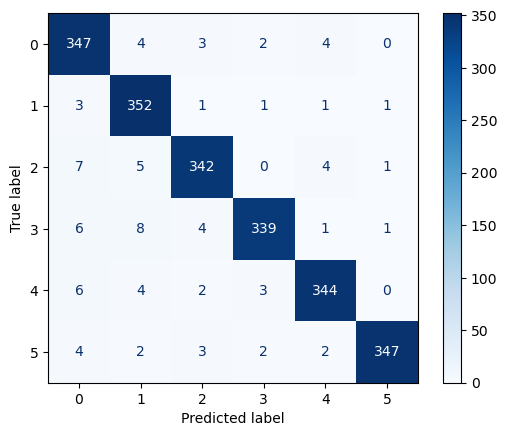

In [87]:
evaluate_train_test(rf, X_input_train, X_input_test, y_train, y_test)

In [90]:
xgb = XGBClassifier( 
    eval_metric="logloss",    
    n_jobs=-1,                
    random_state=42
)


In [91]:
results_1 = stratified_kfold_eval(X_input_train,y_train,xgb,n_splits=5)

In [92]:
results_1

,mean_accuracy,std_accuracy,mean_f1,std_f1
0,0.955705,0.002419,0.955807,0.002404


Accuracy: 0.9606
F1 Score (macro): 0.9606

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       360
           1       0.96      0.97      0.97       359
           2       0.95      0.95      0.95       359
           3       0.99      0.96      0.97       359
           4       0.94      0.95      0.94       359
           5       0.99      0.97      0.98       360

    accuracy                           0.96      2156
   macro avg       0.96      0.96      0.96      2156
weighted avg       0.96      0.96      0.96      2156



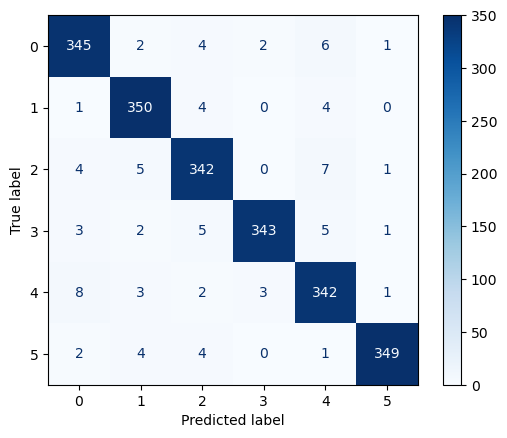

In [93]:
evaluate_train_test(xgb, X_input_train, X_input_test, y_train, y_test)

In [96]:
svc = LinearSVC(random_state=42,max_iter=10000)

In [97]:
results_2 = stratified_kfold_eval(X_input_train,y_train,svc,n_splits=5)

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [98]:
results_2

,mean_accuracy,std_accuracy,mean_f1,std_f1
0,0.970547,0.002152,0.970601,0.002146


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9736
F1 Score (macro): 0.9736

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       360
           1       0.97      0.98      0.97       359
           2       0.97      0.96      0.97       359
           3       0.99      0.97      0.98       359
           4       0.97      0.97      0.97       359
           5       0.99      0.98      0.99       360

    accuracy                           0.97      2156
   macro avg       0.97      0.97      0.97      2156
weighted avg       0.97      0.97      0.97      2156



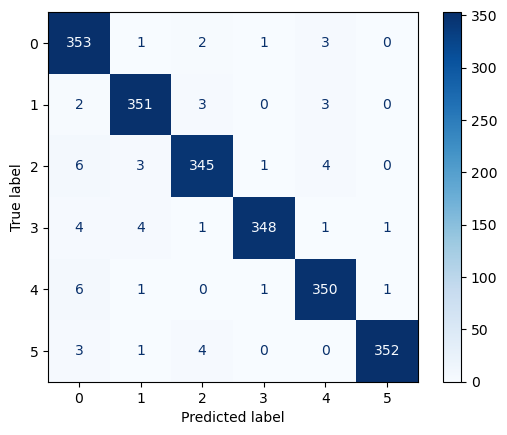

In [99]:
evaluate_train_test(svc, X_input_train, X_input_test, y_train, y_test)

In [100]:
lgbm = LGBMClassifier(
    objective="multiclass",
    n_jobs=-1,
    random_state=42
)

In [101]:
result_lgb = stratified_kfold_eval(X_input_train,y_train,lgbm,n_splits=5)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41515
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 2041
[LightGBM] [Info] Start training from score -1.789877
[LightGBM] [Info] Start training from score -1.791615
[LightGBM] [Info] Start training from score -1.792484
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.789877


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41733
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 2058
[LightGBM] [Info] Start training from score -1.789877
[LightGBM] [Info] Start training from score -1.791615
[LightGBM] [Info] Start training from score -1.792484
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.789877


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41999
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 2062
[LightGBM] [Info] Start training from score -1.789877
[LightGBM] [Info] Start training from score -1.792484
[LightGBM] [Info] Start training from score -1.791615
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.789877


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41932
[LightGBM] [Info] Number of data points in the train set: 6899, number of used features: 2049
[LightGBM] [Info] Start training from score -1.789877
[LightGBM] [Info] Start training from score -1.792484
[LightGBM] [Info] Start training from score -1.791615
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.793355
[LightGBM] [Info] Start training from score -1.789877


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41855
[LightGBM] [Info] Number of data points in the train set: 6900, number of used features: 2029
[LightGBM] [Info] Start training from score -1.790022
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.793500
[LightGBM] [Info] Start training from score -1.793500
[LightGBM] [Info] Start training from score -1.790022


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [91]:
result_lgb

,mean_accuracy,std_accuracy,mean_f1,std_f1
0,0.954661,0.004748,0.954716,0.004737


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51724
[LightGBM] [Info] Number of data points in the train set: 8624, number of used features: 2296
[LightGBM] [Info] Start training from score -1.789906
[LightGBM] [Info] Start training from score -1.791991
[LightGBM] [Info] Start training from score -1.791991
[LightGBM] [Info] Start training from score -1.793384
[LightGBM] [Info] Start training from score -1.793384
[LightGBM] [Info] Start training from score -1.789906


D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


Accuracy: 0.9573
F1 Score (macro): 0.9574

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       360
           1       0.96      0.96      0.96       359
           2       0.94      0.96      0.95       359
           3       0.97      0.94      0.96       359
           4       0.94      0.95      0.95       359
           5       0.99      0.96      0.98       360

    accuracy                           0.96      2156
   macro avg       0.96      0.96      0.96      2156
weighted avg       0.96      0.96      0.96      2156



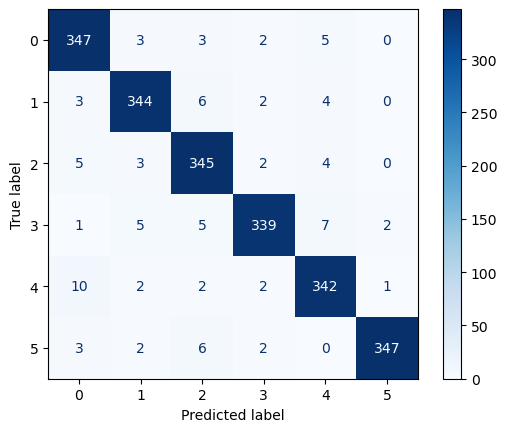

In [92]:
evaluate_train_test(lgbm, X_input_train, X_input_test, y_train, y_test)

In [104]:
mnb = MultinomialNB()

In [105]:
X_input_train.data = np.maximum(X_input_train.data, 0)
X_input_test.data = np.maximum(X_input_test.data, 0)

In [106]:
result_3 = stratified_kfold_eval(X_input_train,y_train,mnb,n_splits=5)

In [107]:
result_3

,mean_accuracy,std_accuracy,mean_f1,std_f1
0,0.848099,0.009925,0.850484,0.009584


Accuracy: 0.8738
F1 Score (macro): 0.8759

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.90       360
           1       0.77      0.94      0.84       359
           2       0.98      0.78      0.87       359
           3       0.98      0.90      0.94       359
           4       0.75      0.86      0.80       359
           5       0.89      0.91      0.90       360

    accuracy                           0.87      2156
   macro avg       0.89      0.87      0.88      2156
weighted avg       0.89      0.87      0.88      2156



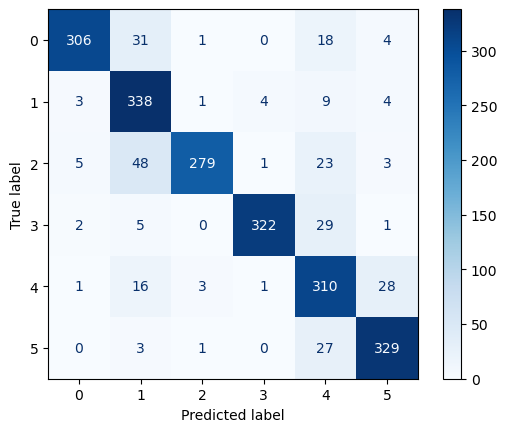

In [108]:
evaluate_train_test(mnb, X_input_train, X_input_test, y_train, y_test)